## Cluster fables with embeddings

In [1]:
from transformers import RobertaModel
from transformers import RobertaTokenizer
import csv 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import pandas
import torch
import csv
import numpy as np

In [22]:
# filtering open classes

data = pandas.read_csv("C:/Users/Thiloshon/PycharmProjects/analogical-transfer-learning/dataset/01_aesop_fables_open_annotated.csv")

a = data['tag'].value_counts()
a = a[a > 3]
keys = list(a.keys())

data_filt = datas[datas.tag.apply(lambda x: x in keys)]

labels = list(data_filt['tag'])
morals = list(data_filt['moral'])
morals = [mor.replace("Moral:", "") for mor in morals]

stories = list(data_filt['story'])

data_filt

,Unnamed: 0,url,title,story,moral,category,tag
1,1,https://www.litscape.com/author/Aesop/The_Ants...,The Ants and the Grasshopper,THE ANTS were employing a fine winter's day in...,Moral:Idleness brings want.,life,lazy
2,2,https://www.litscape.com/author/Aesop/The_Ass_...,The Ass and His Driver,"AN ASS, being driven along a high road, sudden...",Moral:The perverse generally come to harm.,life,danger
3,3,https://www.litscape.com/author/Aesop/The_Ass_...,The Ass and His Purchaser,"A MAN wished to purchase an Ass, and agreed wi...",Moral:A man is known by the company he keeps.,life,friends
4,4,https://www.litscape.com/author/Aesop/The_Ass_...,The Ass and His Shadow,A TRAVELER hired an Ass to convey him to a dis...,"Moral:In quarreling about the shadow, we often...",life,worthiness
8,8,https://www.litscape.com/author/Aesop/The_Ass_...,The Ass and the Wolf,"AN ASS, feeding in a meadow, saw a Wolf approa...",Moral:Everyone has his trade.,life,worthiness
...,...,...,...,...,...,...,...
224,224,https://www.litscape.com/author/Aesop/The_Wolf...,The Wolf and the Crane,"A WOLF, having a bone stuck in his throat, hir...","Moral:In serving the wicked, expect no reward,...",life,consequence
226,226,https://www.litscape.com/author/Aesop/The_Wolf...,The Wolf and the Horse,A WOLF coming out of a field of oats met a Hor...,"Moral:Men of evil reputation, when they perfor...",life,true-nature
230,230,https://www.litscape.com/author/Aesop/The_Wolf...,The Wolf and the Sheep,"A WOLF, being sick and maimed, called to a She...",Moral:Hypocritical speeches are easily seen th...,life,true-nature
234,234,https://www.litscape.com/author/Aesop/The_Wolf...,"The Wolf, The Goat, And The Kid","AS AN OLD GOAT was going forth to pasture, she...",Moral:Two sureties are better than one.,motivation,greed


In [5]:
data_filt.to_csv('dataset/02_aesop_fables_annotated.csv', encoding='utf-8')

In [30]:
datas= pandas.read_csv("C:/Users/Thiloshon/PycharmProjects/analogical-transfer-learning/dataset/02_aesop_fables_annotated.csv")
datas = data.sample(frac = 1)

labels = list(datas['tag'])
morals = list(datas['moral'])

stories = list(datas['story'])

print(len(labels))

116


In [31]:
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
n_elements = len(morals)

print(categories)

['consequence', 'content', 'danger', 'effort', 'flattery', 'friends', 'greed', 'lazy', 'learn', 'opportunity', 'respect', 'true-nature', 'trust', 'weak', 'worthiness']


## Tuning model for classification

In [ ]:
from transformers import DebertaTokenizer, DebertaModel, \
    DebertaForSequenceClassification
from transformers import AlbertConfig, AlbertModel, RobertaModel
from transformers import AlbertTokenizer, \
    AlbertForSequenceClassification

categories = sorted(list(set(labels)))
n_categories = len(categories)
n_elements = len(morals)


def indicize_labels(labels):
    """Transforms string labels into indices"""

    indices = []
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j] == categories[i]:
                indices.append(i)
    return indices


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs = tokenizer(morals)

indices = indicize_labels(labels)

dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), indices))  # Create a tensorflow dataset

# train test split, we use 20% of the data for validation

val_data_size = int(0.2 * n_elements)

val_ds = dataset.take(val_data_size).batch(4, drop_remainder=True)
train_ds = dataset.skip(val_data_size).batch(4, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

y = np.concatenate([y for (x, y) in val_ds], axis=0)


class PredictionCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        y_pred = model.predict(val_ds)
        print '\n'
        print [np.argmax(a) for a in y_pred['logits']]
        print 'prediction: {} at epoch: {}'.format(np.argmax(y_pred['logits'
                ]), epoch)


model = \
    TFAutoModelForSequenceClassification.from_pretrained('roberta-base'
        , num_labels=n_categories)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5,
              clipnorm=1.),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.SparseCategoricalAccuracy(),
              tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3,
              name='Sparse_Top_3_Categorical_Accuracy')])

history = model.fit(train_ds, validation_data=val_ds, epochs=12,
                    verbose=1, callbacks=[PredictionCallback()])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()


In [ ]:
# Tuning model

from transformers import RobertaTokenizer

categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
n_elements = len(morals)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

tokenizer = RobertaTokenizer.from_pretrained("roberta-base") #Tokenizer
indices=indicize_labels(labels)

input_ids = []
attention_masks = []

# For every sentence...
for sent in morals:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'tf',     # Return pytorch tensors.
                        padding = "max_length"
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


dataset=tf.data.Dataset.from_tensor_slices((dict(input_ids), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(8, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(8, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')],
    )
    
history=model.fit(train_ds, validation_data=val_ds, epochs=12, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [10]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
n_elements = len(morals)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

tokenizer = RobertaTokenizer.from_pretrained("roberta-base") #Tokenizer
indices=indicize_labels(labels)

# For every sentence...
for sent in morals:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
indices = torch.tensor(indices)

# Print sentence 0, now as a list of IDs.
print('Original: ', morals[0])
print('Token IDs:', input_ids[0])

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, indices)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Traitors must expect treachery.
Token IDs: tensor([    0, 24523,  9314,   531,  1057, 45492,   219,     4,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
          

In [ ]:
# Generate embedding cluster to be viewed in Google Tensor

with open('output_tuned_roberta.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    toks = tokenizer(morals, 
                   add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   max_length = 64,
                   pad_to_max_length = True,
                   return_tensors = 'tf',     # Return pytorch tensors.
                   padding = "max_length")
    outputs = model(toks, output_hidden_states= True)
    hidden_states = outputs['hidden_states']
    embedding_output = hidden_states[0]
    
    avg_vector = tf.reduce_mean(embedding_output, 2)
    for i in range(0, 116):
        b = avg_vector[i].numpy().tolist()
        tsv_output.writerow(b)
        
with open('output_tuned_roberta_metadata.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    a = list(range(0,768))
    a.append("class")
    tsv_output.writerow(a)
    for idx, w in enumerate(morals):
        a = list(range(0,768))
        a.append(labels[idx])
        tsv_output.writerow(a)

In [ ]:
# Creating embeddings without fine-tuning

from transformers import RobertaTokenizer, RobertaModel
import torch

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base") 

with open('output_tuned_roberta.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for idx, w in enumerate(morals):
        
        toks = tokenizer(w, 
               return_tensors = 'pt')
        outputs = model(toks)
        hidden_states = outputs['hidden_states']
        embedding_output = hidden_states[0]
                
        avg_vector = tf.reduce_mean(embedding_output, 2)
        b = avg_vector.numpy().tolist()[0]
        tsv_output.writerow(b)
        
with open('output_tuned_roberta_metadata.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    a = list(range(0,768))
    a.append("class")
    tsv_output.writerow(a)
    for idx, w in enumerate(morals):
        a = list(range(0,768))
        a.append(labels[idx])
        tsv_output.writerow(a)

In [42]:
# USING MEAN POOLING for sentence representation

from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Sentences we want sentence embeddings for
sentences = morals

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
# create visualization data of embeddings

with open('aesop_embedding_sentence_pooled.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    
    for index, row in enumerate(sentence_embeddings):        
        b = row.tolist()
        tsv_output.writerow(b)
        
        
with open('aesop_embedding_sentence_pooled_meta.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    a = list(range(0,384))
    a.append("class")
    tsv_output.writerow(a)
    
    for index, row in enumerate(labels):
        a = list(range(0,384))
        a.append(labels[index])
        tsv_output.writerow(a)

In [ ]:
# USING SENTENCE TRANFORMERS, untuned

import csv

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')

with open('aesop_embedding_sentence_untuned.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    
    for index, row in enumerate(morals):
        b = model.encode(row).tolist()
        tsv_output.writerow(b)
        
        
with open('aesop_embedding_sentence_untuned_meta.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    a = list(range(0,384))
    a.append("class")
    tsv_output.writerow(a)
    
    for index, row in enumerate(labels):
        a = list(range(0,384))
        a.append(labels[index])
        tsv_output.writerow(a)

In [39]:
# Moral similarity with Cosine

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

#Compute embeddings
embeddings = model.encode(morals, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs:     
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(morals[i], morals[j], pair['score']))
    print("\n")

Our insignificance is often the cause of our safety. 		 What is safety to one is not always safety to another. 		 Score: 0.6804


Flattery is a dangerous weapon in the hands of the enemy. 		 Flattery is not a proof of admiration. 		 Score: 0.6478


He who listens to flattery is not wise, for it has no good purpose 		 Flattery is a dangerous weapon in the hands of the enemy. 		 Score: 0.6430


He who listens to flattery is not wise, for it has no good purpose 		 Flattery is not a proof of admiration. 		 Score: 0.6346


Misfortune tests the sincerity of friends. 		 It shows an evil disposition to take advantage of a friend in distress. 		 Score: 0.6054


By too much attention to danger, we may fall victims to it. 		 Better a little in safety, than an abundance surrounded by danger. 		 Score: 0.6053


Distance exaggerates dangers. 		 Better a little in safety, than an abundance surrounded by danger. 		 Score: 0.5948


Our insignificance is often the cause of our safety. 		 Better a little

He who will steal a part will steal the whole. 		 The greedy man and the miser cannot enjoy their gains. 		 Score: 0.3396


Kindness to the ungrateful and the vicious is thrown away. 		 Those who try to entrap others are sometimes caught by their own schemes. 		 Score: 0.3396


Kindness to the ungrateful and the vicious is thrown away. 		 Those who neglect their old friends for the sake of new ones, are rightly served if they lose both. 		 Score: 0.3395


We should never look so high as to miss seeing the things that are around us.  		 Distance exaggerates dangers. 		 Score: 0.3395


Those who practice cunning must expect to suffer by it. 		 No one is too weak to do good. 		 Score: 0.3390


Happy is the man who learns from the misfortunes of others. 		 Evil companions bring more hurt than profit. 		 Score: 0.3386


Kindness to the ungrateful and the vicious is thrown away. 		 By endeavoring to please everybody, one succeeds in pleasing nobody. 		 Score: 0.3386


We are encouraged by se



He who will steal a part will steal the whole. 		 Let every one stick to his own element. 		 Score: 0.2917


It shows an evil disposition to take advantage of a friend in distress. 		 By too much attention to danger, we may fall victims to it. 		 Score: 0.2916


A man is known by the company he keeps. 		 He who will steal a part will steal the whole. 		 Score: 0.2916


In injuring others we are apt to receive greater injury. 		 The vices we teach may be practiced against us. 		 Score: 0.2916


One story is good, till another is told. 		 Inconsiderate and ill-matched alliances generally end in ruin; and the man who compasses the destruction of his neighbor is often caught in his own snare. 		 Score: 0.2914


A man who can strike from a distance is no pleasant neighbor. 		 Distance exaggerates dangers. 		 Score: 0.2913


The greedy man and the miser cannot enjoy their gains. 		 Let every one stick to his own element. 		 Score: 0.2911


Much wants more, and loses all. 		 Some men despis

Everyone has his trade. 		 He who seeks to injure others often injures only himself. 		 Score: 0.2592


Everyone to his taste: one man's meat is another man's poison, and one mans poison is another man's meat; what is rejected by one person may be valued very highly by another. 		 They who assue a character will betray themselves by their actions. 		 Score: 0.2591


Everyone to his taste: one man's meat is another man's poison, and one mans poison is another man's meat; what is rejected by one person may be valued very highly by another. 		 Those who stir up enmities are not to be trusted. 		 Score: 0.2590


No one should be blamed for his infirmities. 		 If men had all they wished, they would be often ruined. 		 Score: 0.2590


He who seeks to injure others often injures only himself. 		 By endeavoring to please everybody, one succeeds in pleasing nobody. 		 Score: 0.2589


We should not wait till a person is dead, to give him our respect. 		 They who assue a character will betray the

Incentive spurs effort. 		 He who slights his friends when they are not needed must not expect them to serve him when he needs them. 		 Score: 0.2383


Men often fall into the trap which they prepare for others. 		 He who once begins to tell falsehoods is obliged to tell others to make them appear true, and, sooner or later, they will get him into trouble. 		 Score: 0.2383


By endeavoring to please everybody, one succeeds in pleasing nobody. 		 Do nothing without a regard to the consequences. 		 Score: 0.2382


Do not attempt too much at once. 		 If you wish to do a service, do it right. 		 Score: 0.2382


No one should be blamed for his infirmities. 		 He who offers bribes needs watching, for his intentions are not honest. 		 Score: 0.2382


Flattery is not a proof of admiration. 		 He who offers bribes needs watching, for his intentions are not honest. 		 Score: 0.2381


Those who suffer most cry out the least. 		 Evil companions bring more hurt than profit. 		 Score: 0.2381


If wo

It is not wise to be too greedy. 		 Fine weather friends are not worth much. 		 Score: 0.2150


If we nourish evil, it will sooner or later turn upon us. 		 Unlawful acts to escape trials only increase our troubles. 		 Score: 0.2150


Idleness brings want. 		 No one is too weak to do good. 		 Score: 0.2149


A fair face is of little use without sense. 		 Perseverance is surer than swiftness. 		 Score: 0.2148


Flattery is a dangerous weapon in the hands of the enemy. 		 We must make friends in prosperity, if we would have their help in adversity. 		 Score: 0.2148


They who assue a character will betray themselves by their actions. 		 Persuasion is better than Force. 		 Score: 0.2148


Critics are not always to be depended upon. 		 Perseverance is surer than swiftness. 		 Score: 0.2148


Distance exaggerates dangers. 		 Better be wise by the misfortunes of others than by your own. 		 Score: 0.2147


Beware of unequal matches. Alliances prompted by ambition often prove fatal. 		 No one 

We should not wait till a person is dead, to give him our respect. 		 Better a little in safety, than an abundance surrounded by danger. 		 Score: 0.1973


The weak often revenge themselves on those who use them ill, even though they be the more powerful. 		 Hypocritical speeches are easily seen through. 		 Score: 0.1973


What we do in sport often makes great trouble for others. 		 He who once begins to tell falsehoods is obliged to tell others to make them appear true, and, sooner or later, they will get him into trouble. 		 Score: 0.1973


Much wants more, and loses all. 		 Flattery is not a proof of admiration. 		 Score: 0.1973


Perseverance is surer than swiftness. 		 Unlawful acts to escape trials only increase our troubles. 		 Score: 0.1972


The poor and the weak are often made to suffer for the follies of the great. 		 No one should be blamed for his infirmities. 		 Score: 0.1972


What we do in sport often makes great trouble for others. 		 Those who do not know their right 

Those who practice deceit must expect to be shunned. 		 Whatever you do, do with all your might. 		 Score: 0.1825


Distance exaggerates dangers. 		 There is always some vulnerable part in the strongest armor. 		 Score: 0.1824


No disguise will hide one's true character. 		 Two blacks do not make one white. 		 Score: 0.1824


Birds of a feather flock together. 		 Change not friends for foes. 		 Score: 0.1824


Flattery is a dangerous weapon in the hands of the enemy. 		 In serving the wicked, expect no reward, and be thankful if you escape injury for your pains. 		 Score: 0.1823


We should never look so high as to miss seeing the things that are around us.  		 If men had all they wished, they would be often ruined. 		 Score: 0.1823


The weak often revenge themselves on those who use them ill, even though they be the more powerful. 		 The conspicuous run the greatest risk. 		 Score: 0.1823


In injuring others we are apt to receive greater injury. 		 Those who are not able to roam sh

Whatever you do, do with all your might. 		 Attempt not impossibilities. 		 Score: 0.1663


It is absurd to ape our betters. 		 We should not think wholly of ourselves, and we should remember that life is uncertain. 		 Score: 0.1663


Beware of unequal matches. Alliances prompted by ambition often prove fatal. 		 The memory of a good deed lives. 		 Score: 0.1663


Those who practice deceit must expect to be shunned. 		 Fine feathers don't make fine birds. 		 Score: 0.1663


Traitors must expect treachery. 		 Some men despise their best blessings because they come without cost. 		 Score: 0.1663


Whatever you do, do with all your might. 		 Change of habit cannot alter Nature. 		 Score: 0.1663


Incentive spurs effort. 		 Let every one stick to his own element. 		 Score: 0.1663


Traitors must expect treachery. 		 What we do in sport often makes great trouble for others. 		 Score: 0.1662


What we do in sport often makes great trouble for others. 		 The memory of a good deed lives. 		 Sc

Those who neglect their old friends for the sake of new ones, are rightly served if they lose both. 		 Might makes right. 		 Score: 0.1508


The same measures will not suit all circumstances. 		 He who offers bribes needs watching, for his intentions are not honest. 		 Score: 0.1508


He who slights his friends when they are not needed must not expect them to serve him when he needs them. 		 It is absurd to ape our betters. 		 Score: 0.1508


Do not presume to teach your elders. 		 When you seek to change your condition, be sure that you can better it. 		 Score: 0.1508


A man who can strike from a distance is no pleasant neighbor. 		 Fine feathers don't make fine birds. 		 Score: 0.1508


He who stops to parley with temptation, will be very likely to yield. 		 The desire for imaginary benefits often involves the loss of present blessings. 		 Score: 0.1507


It is wise to turn circumstances to good account. 		 That which we are anxious to find, we are sometimes even more anxious to esc

No disguise will hide one's true character. 		 In yielding the rights of others, we may endanger our own. 		 Score: 0.1356


Look before you leap. 		 Change of habit cannot alter Nature. 		 Score: 0.1356


Idleness brings want. 		 Let every one stick to his own element. 		 Score: 0.1356


Every one should keep his own colors. 		 Those who suffer most cry out the least. 		 Score: 0.1355


Avoid even appearances of danger. 		 No one should be blamed for his infirmities. 		 Score: 0.1355


Those who stir up enmities are not to be trusted. 		 The memory of a good deed lives. 		 Score: 0.1355


Those who enter by the back stairs must not complain if they are thrown out by the window. 		 Flattery is not a proof of admiration. 		 Score: 0.1355


A man who can strike from a distance is no pleasant neighbor. 		 Those who try to entrap others are sometimes caught by their own schemes. 		 Score: 0.1354


Those who practice deceit must expect to be shunned. 		 Inconsiderate and ill-matched allianc

Fine feathers don't make fine birds. 		 Unlawful acts to escape trials only increase our troubles. 		 Score: 0.1183


The same measures will not suit all circumstances. 		 Those who practice cunning must expect to suffer by it. 		 Score: 0.1182


A man is known by the company he keeps. 		 No disguise will hide one's true character. 		 Score: 0.1182


Avoid even appearances of danger. 		 It is too late to whet the sword when the trumpet sounds to draw it. 		 Score: 0.1182


Cure a boaster by putting his words to the test. 		 Danger sometimes comes from a source that is least suspected. 		 Score: 0.1182


He who once begins to tell falsehoods is obliged to tell others to make them appear true, and, sooner or later, they will get him into trouble. 		 Our mere anticipations of life outrun its realities. 		 Score: 0.1181


There is always some vulnerable part in the strongest armor. 		 Those who neglect their old friends for the sake of new ones, are rightly served if they lose both. 		 Sco

Misfortune tests the sincerity of friends. 		 Do not attempt too much at once. 		 Score: 0.0986


Those who enter by the back stairs must not complain if they are thrown out by the window. 		 Two sureties are better than one. 		 Score: 0.0986


Those who practice deceit must expect to be shunned. 		 Happy is the man who learns from the misfortunes of others. 		 Score: 0.0984


Pride goes before destruction. 		 Those who are not able to roam should stay at home. 		 Score: 0.0984


The misfortunes arising from a man's own misconduct are the hardest to bear. 		 Two blacks do not make one white. 		 Score: 0.0984


The same measures will not suit all circumstances. 		 Misfortune tests the sincerity of friends. 		 Score: 0.0984


Do not attempt too much at once. 		 Those who stir up enmities are not to be trusted. 		 Score: 0.0984


The grateful heart will always find opportunities to show its gratitude. 		 A bird in the hand is worth two in the bush. 		 Score: 0.0983


No disguise will hide

One story is good, till another is told. 		 Change of habit cannot alter Nature. 		 Score: 0.0766


It is wise to turn circumstances to good account. 		 The value is in the worth, not in the number. 		 Score: 0.0766


The basest ingratitude is that which injures those who serve us. 		 Change not friends for foes. 		 Score: 0.0765


Look before you leap. 		 There is always some vulnerable part in the strongest armor. 		 Score: 0.0765


He who will steal a part will steal the whole. 		 Keep to your place, if you would succeed. 		 Score: 0.0765


If we nourish evil, it will sooner or later turn upon us. 		 Two blacks do not make one white. 		 Score: 0.0765


Distance exaggerates dangers. 		 Let every one stick to his own element. 		 Score: 0.0765


Whatever you do, do with all your might. 		 That which we are anxious to find, we are sometimes even more anxious to escape from, when we have succeeded in finding it. 		 Score: 0.0765


Everyone to his taste: one man's meat is another man's po

Do not attempt too much at once. 		 The grateful heart will always find opportunities to show its gratitude. 		 Score: 0.0478


Incentive spurs effort. 		 A man who talks for both sides is not to be trusted by either. 		 Score: 0.0477


Idleness brings want. 		 Avoid a remedy that is worse than the disease. 		 Score: 0.0476


When you seek to change your condition, be sure that you can better it. 		 Some men despise their best blessings because they come without cost. 		 Score: 0.0476


Happy is the man who learns from the misfortunes of others. 		 Avoid a remedy that is worse than the disease. 		 Score: 0.0475


We should not wait till a person is dead, to give him our respect. 		 Those who try to entrap others are sometimes caught by their own schemes. 		 Score: 0.0473


That which we are anxious to find, we are sometimes even more anxious to escape from, when we have succeeded in finding it. 		 He who slights his friends when they are not needed must not expect them to serve him whe

The grateful heart will always find opportunities to show its gratitude. 		 People are not to be judged by their coats. 		 Score: -0.0355


Those who stir up enmities are not to be trusted. 		 When you seek to change your condition, be sure that you can better it. 		 Score: -0.0358


Everyone has his trade. 		 Hypocritical speeches are easily seen through. 		 Score: -0.0367


Those who practice deceit must expect to be shunned. 		 A bird in the hand is worth two in the bush. 		 Score: -0.0371


Avoid a remedy that is worse than the disease. 		 If you wish to do a service, do it right. 		 Score: -0.0375


Avoid a remedy that is worse than the disease. 		 What is most truly valuable is often underrated. 		 Score: -0.0376


A man is known by the company he keeps. 		 Because we are like the great in one respect, we must not think we are like them in all. 		 Score: -0.0378


A man is known by the company he keeps. 		 No one is too weak to do good. 		 Score: -0.0380


Do not attempt too much

In [40]:
# Clustering experiment

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = morals
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) 
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['Idleness brings want.', 'In quarreling about the shadow, we often lose the substance.', 'The poor and the weak are often made to suffer for the follies of the great.', 'Those who try to entrap others are sometimes caught by their own schemes.', 'The weak often revenge themselves on those who use them ill, even though they be the more powerful.', 'Those who practice cunning must expect to suffer by it.', 'We are encouraged by seeing others that are worse off than ourselves.', 'The lives of the idle can best be sacrificed.', 'Laziness often prepares a burden for its own back.', 'The desire for imaginary benefits often involves the loss of present blessings.', 'Those who strive are often watched by others who will take advantage of their defeat to benefit themselves', 'No one is too weak to do good.', 'Better be wise by the misfortunes of others than by your own.', 'Those who suffer most cry out the least.']

Cluster  10
['The perverse generally come to harm.', 'If we nourish

# Frame Net

In [130]:
#Using the pased frames for each tag

import re
import nltk.data

data = pandas.read_csv("C:/Users/Thiloshon/PycharmProjects/analogical-transfer-learning/dataset/02_aesop_fables_annotated.csv")
data = data.sample(frac = 1)

data_filt = data[data.tag.apply(lambda x: x == "friends")]

with open('aesopmorals_for_framing_friends.txt', 'w', newline='') as f_output:
  
    for index, row in enumerate(data_filt['story']):
        
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

        for a in tokenizer.tokenize(row):
            f_output.write(a + "\n")
            
        f_output.write("YAHOO" + "\n") # Seperating story as stories are broken into multiple lines

                                                  url  \
39  https://www.litscape.com/author/Aesop/The_Dog_...   
36  https://www.litscape.com/author/Aesop/The_Bowm...   
45  https://www.litscape.com/author/Aesop/The_Porc...   
34  https://www.litscape.com/author/Aesop/The_Bear...   
40  https://www.litscape.com/author/Aesop/The_Farm...   
42  https://www.litscape.com/author/Aesop/The_Hors...   
50  https://www.litscape.com/author/Aesop/The_Two_...   
43  https://www.litscape.com/author/Aesop/The_Lamb...   
35  https://www.litscape.com/author/Aesop/The_Bear...   
46  https://www.litscape.com/author/Aesop/The_Rat_...   
37  https://www.litscape.com/author/Aesop/The_Bull...   
38  https://www.litscape.com/author/Aesop/The_Char...   
51  https://www.litscape.com/author/Aesop/The_Wolv...   
49  https://www.litscape.com/author/Aesop/The_Swal...   
33  https://www.litscape.com/author/Aesop/The_Ass_...   
44  https://www.litscape.com/author/Aesop/The_Part...   
41  https://www.litscape.com/au

## Word2vec

In [11]:
from nltk.corpus import stopwords
import nltk
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import pandas as pd

W2V_PATH="GoogleNews-vectors-negative300.bin"
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

datas = pd.read_csv("C:/Users/Thiloshon/PycharmProjects/analogical-transfer-learning/dataset/02_aesop_fables_annotated.csv")

documents_df=pandas.DataFrame(datas,columns=['story'])

# removing special characters and stop words from the text
stop_words_l=stopwords.words('english')
documents_df['documents_cleaned']=documents_df.story.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )


In [12]:
# TF-IDF for sentence weighting

from sklearn.feature_extraction.text import TfidfVectorizer 

tokenizer=Tokenizer()
tokenizer.fit_on_texts(documents_df.documents_cleaned)
tokenized_documents=tokenizer.texts_to_sequences(documents_df.documents_cleaned)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=64,padding='post')
vocab_size=len(tokenizer.word_index)+1

tfidfvectoriser=TfidfVectorizer()
tfidfvectoriser.fit(documents_df.documents_cleaned)
tfidf_vectors=tfidfvectoriser.transform(documents_df.documents_cleaned)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]
# creating document-word embeddings
document_word_embeddings=np.zeros((len(tokenized_paded_documents),64,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
print(document_word_embeddings.shape)

# calculating average of word vectors of a document weighted by tf-idf
document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=tfidfvectoriser.get_feature_names()
for i in range(len(document_word_embeddings)):
    for j in range(len(words)):
        document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i, j]
        
        
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

(116, 64, 300)


In [17]:
pairwise_similarities

array([[1.        , 0.55261158, 0.62123109, ..., 0.61339207, 0.59348442,
        0.62813616],
       [0.55261158, 1.        , 0.77449673, ..., 0.68949506, 0.71339512,
        0.75041821],
       [0.62123109, 0.77449673, 1.        , ..., 0.70001885, 0.7657868 ,
        0.75863213],
       ...,
       [0.61339207, 0.68949506, 0.70001885, ..., 1.        , 0.75452339,
        0.69898261],
       [0.59348442, 0.71339512, 0.7657868 , ..., 0.75452339, 1.        ,
        0.72748393],
       [0.62813616, 0.75041821, 0.75863213, ..., 0.69898261, 0.72748393,
        1.        ]])

In [32]:
def most_similar(doc_id,similarity_matrix,matrix):
   
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
        
    print(similar_ix)    
    print(similar_ix[1])  
    print(datas["story"][similar_ix[1]])
        
        
for index1, dataset1 in enumerate(pairwise_similarities):
    most_similar(index1,pairwise_similarities,'Cosine Similarity')

[  0  69  18  99  75  94 112  66  40  10   6  12  82  62   7  39  71  48
  33   4  22  29  61  38 104  68  17  84  54  27 100 115  34  50  93  96
  13   2  91 103  59  32  16  67 113  57  46  15  55  73  92  43  78  20
  64  31  49 110  30  63  47  52 111  26  42  80  60  21   9 114   8  65
  19  58  24  11  37  95  85  51 101  53  89  90  98 105  79  36  70  74
  45 109  86  72  35   1  25  44  28  23  87   3  81 106   5 107  41  14
  76 108  77  97  88 102  83  56]
69
AN ASS was loaded with good provisions of several sorts, which, in time of harvest, he was carrying into the field for his master and the reapers to dine upon. By the way he met with a fine large Thistle, and, being very hungry, began to mumble it; and while he was doing so he entered into this reflection: How many greedy epicures would think themselves happy, amidst such a variety of delicate viands as I now carry! But to me this bitter, prickly Thistle is more savory and relishing than the most exquisite and sumptuous

Epoch 1/36
23/23 [==============================] - 123s 3s/step - loss: 2.7018 - sparse_categorical_accuracy: 0.1304 - val_loss: 2.6505 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/36
23/23 [==============================] - 66s 3s/step - loss: 2.6852 - sparse_categorical_accuracy: 0.1413 - val_loss: 2.6373 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/36
23/23 [==============================] - 69s 3s/step - loss: 2.6746 - sparse_categorical_accuracy: 0.1413 - val_loss: 2.6052 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/36
23/23 [==============================] - 66s 3s/step - loss: 2.6646 - sparse_categorical_accuracy: 0.1413 - val_loss: 2.5653 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/36
23/23 [==============================] - 66s 3s/step - loss: 2.6420 - sparse_categorical_accuracy: 0.1413 - val_loss: 2.5054 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/36
23/23 [==============================] - 71s 3s/step - loss: 2.6498 - sparse_categorical_accuracy:

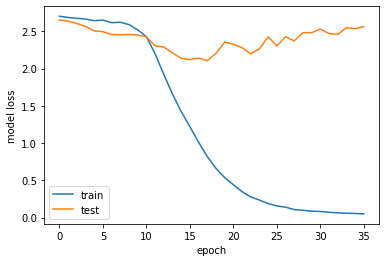

AxisError: axis 1 is out of bounds for array of dimension 1

In [6]:
## Fine tuning with Albert

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt

categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
n_elements = len(morals)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

indices=indicize_labels(labels)

dataset=tf.data.Dataset.from_tensor_slices((input_ids, indices)) #Create a tensorflow dataset
#train test split, we use 20% of the data for validation
val_data_size=int(0.2*n_elements)

val_ds=dataset.take(val_data_size).batch(4, drop_remainder=True)
train_ds=dataset.skip(val_data_size).batch(4, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=n_categories)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
    )
    
history=model.fit(train_ds, validation_data=val_ds, epochs=36, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

y = np.concatenate([y for x, y in val_ds], axis=0)
print(np.argmax(y, axis=1))
print(np.argmax(model.predict(val_ds), axis=1))

In [ ]:
print(y)
a = model.predict(val_ds)

In [29]:
np.argmax(a["logits"], axis=1)

array([ 5, 11, 14,  0,  5,  0, 14,  0,  9, 12,  5,  0,  5,  9,  0,  0,  0,
       14,  0,  6], dtype=int64)

In [4]:
# Fine tuning with [CLS] tag as sentence representation

import transformers as ppb
import pandas
import numpy as np
import torch

datas = pandas.read_csv("C:/Users/Thiloshon/PycharmProjects/analogical-transfer-learning/dataset/02_aesop_fables_annotated.csv")

model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer2 = tokenizer_class.from_pretrained(pretrained_weights)
model2 = model_class.from_pretrained(pretrained_weights)

tokenized = datas["story"].apply((lambda x: tokenizer2.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask).to(torch.int64)

with torch.no_grad():
    last_hidden_states = model2(input_ids, attention_mask=attention_mask)
features = last_hidden_states[0][:,0,:].numpy()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# calculating cosine from enbeddings

from scipy import spatial

dataset1 = features[0]
cosine_distance = []

for index1, dataset1 in enumerate(features):
    dis = []
    for index2, dataset2 in enumerate(features):
        similarity = 1 - spatial.distance.cosine(dataset1, dataset2)
        dis.append(similarity)
    
    cosine_distance.append(dis)
    
    
diss = [[0 if j==1 else j for j in i] for i in cosine_distance]

for index1, dataset1 in enumerate(diss):
    print(datas["story"][np.argmax(dataset1)])

AN ASS was loaded with good provisions of several sorts, which, in time of harvest, he was carrying into the field for his master and the reapers to dine upon. By the way he met with a fine large Thistle, and, being very hungry, began to mumble it; and while he was doing so he entered into this reflection: How many greedy epicures would think themselves happy, amidst such a variety of delicate viands as I now carry! But to me this bitter, prickly Thistle is more savory and relishing than the most exquisite and sumptuous banquet. Let others choose what they may for food, but give me, above everything, a fine juicy thistle like this and I will be content.
A CERTAIN HUCKSTER who kept an Ass, hearing that the Salt was to be had cheap at the sea-side, drove his Ass thither to buy some. Having loaded the beast as much as he could bear, he was driving him home, when, as they were passing a slippery ledge of rock, the Ass fell into the stream below, and the Salt, being melted, the Ass was reli